In [1]:
%load_ext autoreload
%autoreload 2
import os

while not os.getcwd().endswith("naml_exams"):
    os.chdir("..")

# Exercise 1


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We consider a database containing the temperature in four corners of a room as a function of time. Each row of the matrix A refers to a time and each column represents the temperature in a corner of the room.


In [ ]:
data = pd.read_csv("https://openmv.net/file/room-temperature.csv")
labels = ["FrontLeft", "FrontRight", "BackLeft", "BackRight"]
A = data.to_numpy()[:, 1:].astype(np.float64)
A -= 273.15  # from Kelvin to Celsius

How many samples and features are there in the dataset ?


In [ ]:
print(f"There are {A.shape[0]} samples and {A.shape[1]} features.")

There are 144 samples and 4 features.


Plot the values over time of the temperature in the four corners of the room. From the figure, what can you tell about the potential for dimensionality reduction of the dataset?


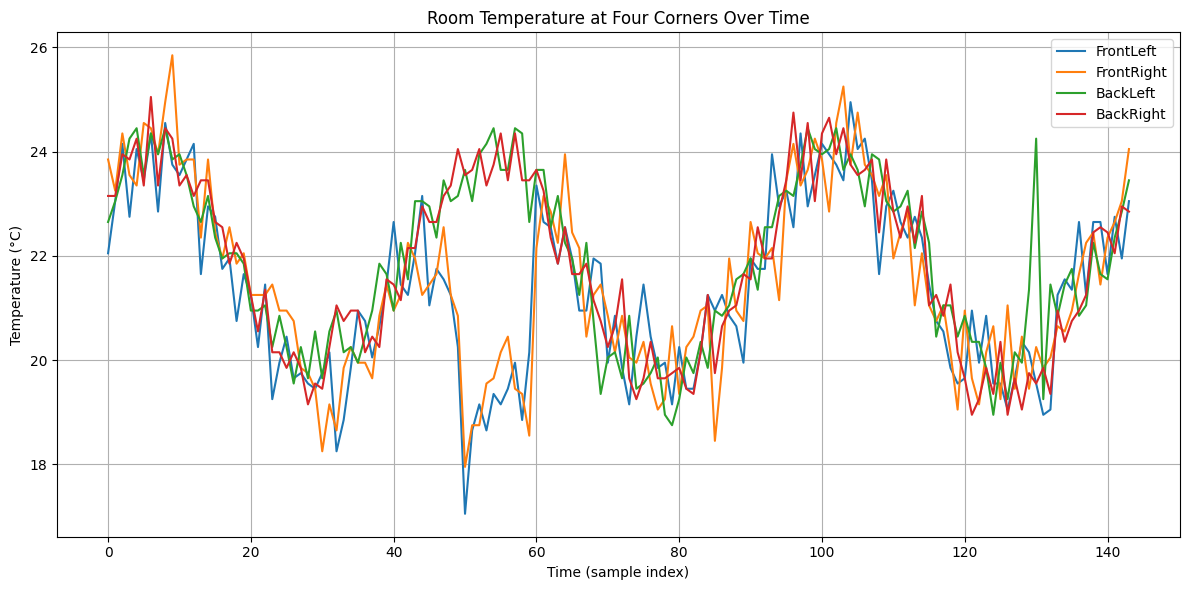

In [ ]:
# Plot the temperature readings over time (sample index as x-axis)
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.plot(A[:, i], label=labels[i])

plt.xlabel("Time (sample index)")
plt.ylabel("Temperature (°C)")
plt.title("Room Temperature at Four Corners Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The four lines track each other closely over time, it suggests strong correlations between the sensor readings.

This implies that the data has low intrinsic dimensionality, despite being in 4D.


Perform PCA on the dataset by means of the SVD decomposition. Then, plot the trend of singular values,cumulative fraction of singular values and explained variance.


(144,)


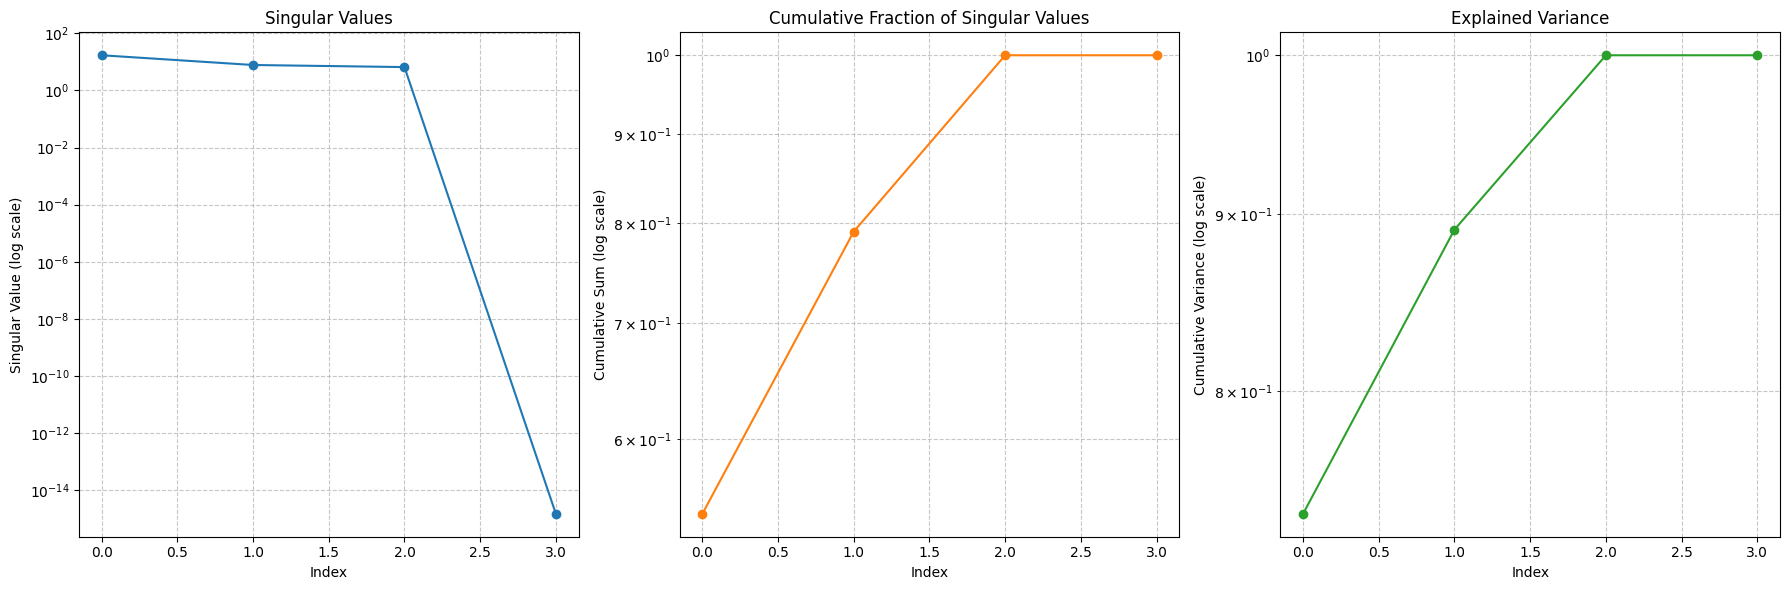

In [ ]:
A_mean = np.mean(A, axis=1)

U, s, VT = np.linalg.svd(A - A_mean[:, None], full_matrices=False)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Singular values plot
axs[0].semilogy(s, "o-", color="tab:blue")
axs[0].set_title("Singular Values")
axs[0].set_xlabel("Index")
axs[0].set_ylabel("Singular Value (log scale)")
axs[0].grid(True, which="both", linestyle="--", alpha=0.7)

# Cumulative fraction of singular values
cumulative_fraction = np.cumsum(s) / np.sum(s)
axs[1].semilogy(cumulative_fraction, "o-", color="tab:orange")
axs[1].set_title("Cumulative Fraction of Singular Values")
axs[1].set_xlabel("Index")
axs[1].set_ylabel("Cumulative Sum (log scale)")
axs[1].grid(True, which="both", linestyle="--", alpha=0.7)

# Explained variance (from squared singular values)
explained_variance = np.cumsum(s**2) / np.sum(s**2)
axs[2].semilogy(explained_variance, "o-", color="tab:green")
axs[2].set_title("Explained Variance")
axs[2].set_xlabel("Index")
axs[2].set_ylabel("Cumulative Variance (log scale)")
axs[2].grid(True, which="both", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

Print the four principal directions.


In [ ]:
Phi = np.matmul(U.transpose(), A - A_mean[:, None])
print(Phi)

[[ 8.99237534e+00  8.04631537e+00 -9.18944576e+00 -7.84924495e+00]
 [-5.35128222e+00  5.62085829e+00 -5.80190120e-01  3.10614055e-01]
 [ 1.74181878e-01 -5.58691334e-01 -4.43754899e+00  4.82205844e+00]
 [ 5.55111512e-16 -1.22124533e-15 -7.07767178e-16  1.80411242e-15]]


By using the principal directions computed above, perform dimensionality reduction using only the first k principal directions. Repeat the exercise for k = 1, 2, 3.


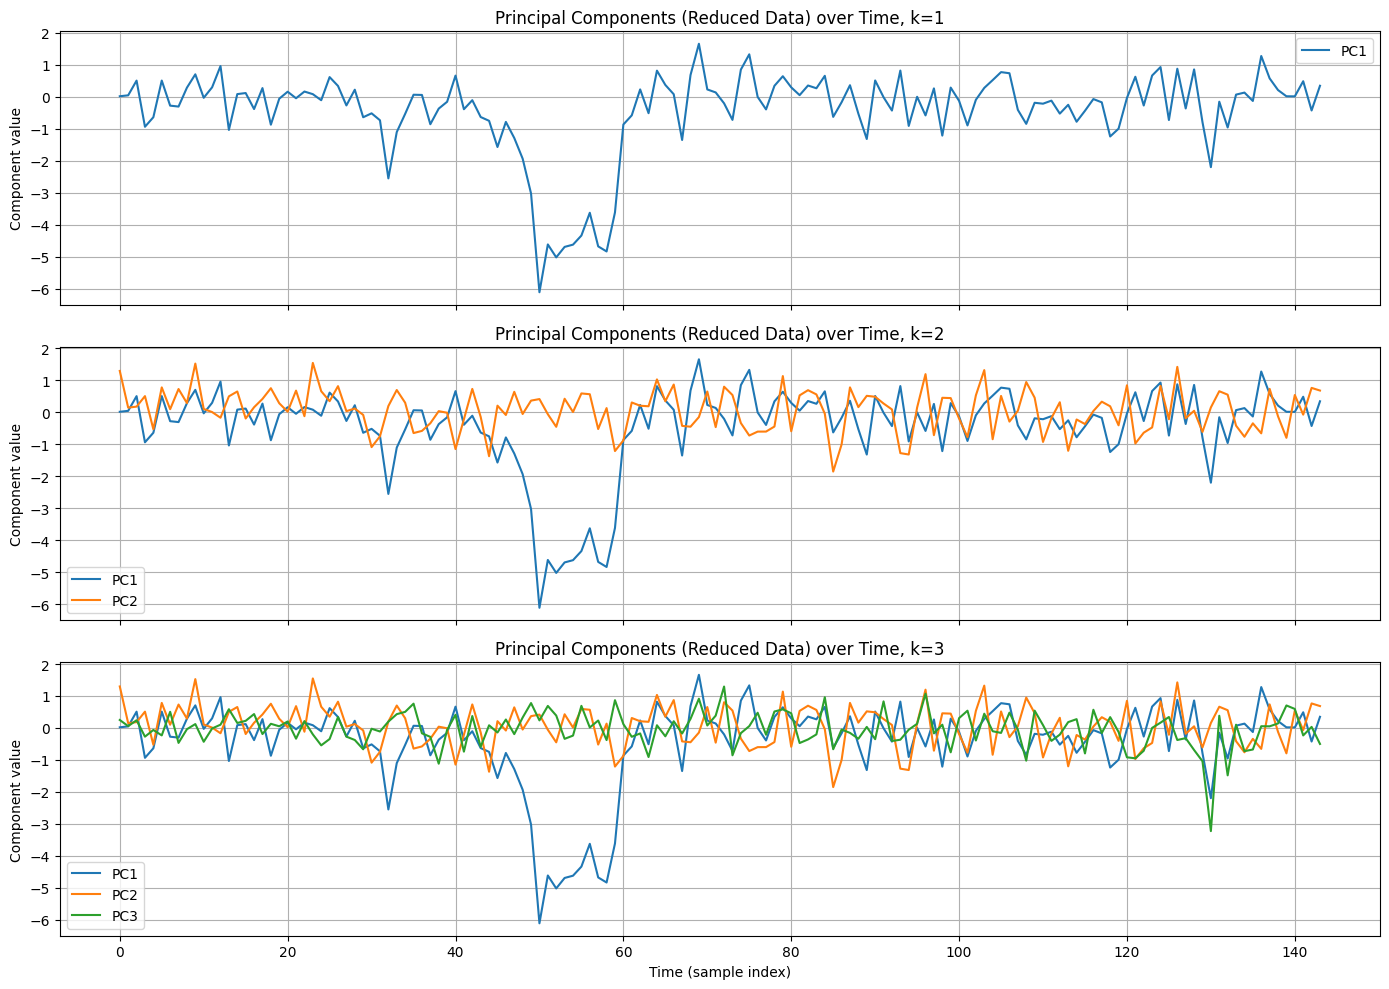

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for idx, k in enumerate([1, 2, 3]):
    Uk = U[:, :k]
    sk = s[:k]
    Sk = np.diag(sk)

    # Scores in reduced space (principal components)
    Zk = Uk @ Sk  # shape: (n_samples, k)

    axs[idx].set_title(f"Principal Components (Reduced Data) over Time, k={k}")

    # Plot each principal component as a separate line
    for comp_idx in range(k):
        axs[idx].plot(Zk[:, comp_idx], label=f"PC{comp_idx + 1}")

    axs[idx].set_ylabel("Component value")
    axs[idx].grid(True)
    axs[idx].legend()

axs[-1].set_xlabel("Time (sample index)")
plt.tight_layout()
plt.show()

Plot the values over time of the temperature in the four corners of the room, obtained from the reconstructions of rank 1, 2 and 3 obtained above.


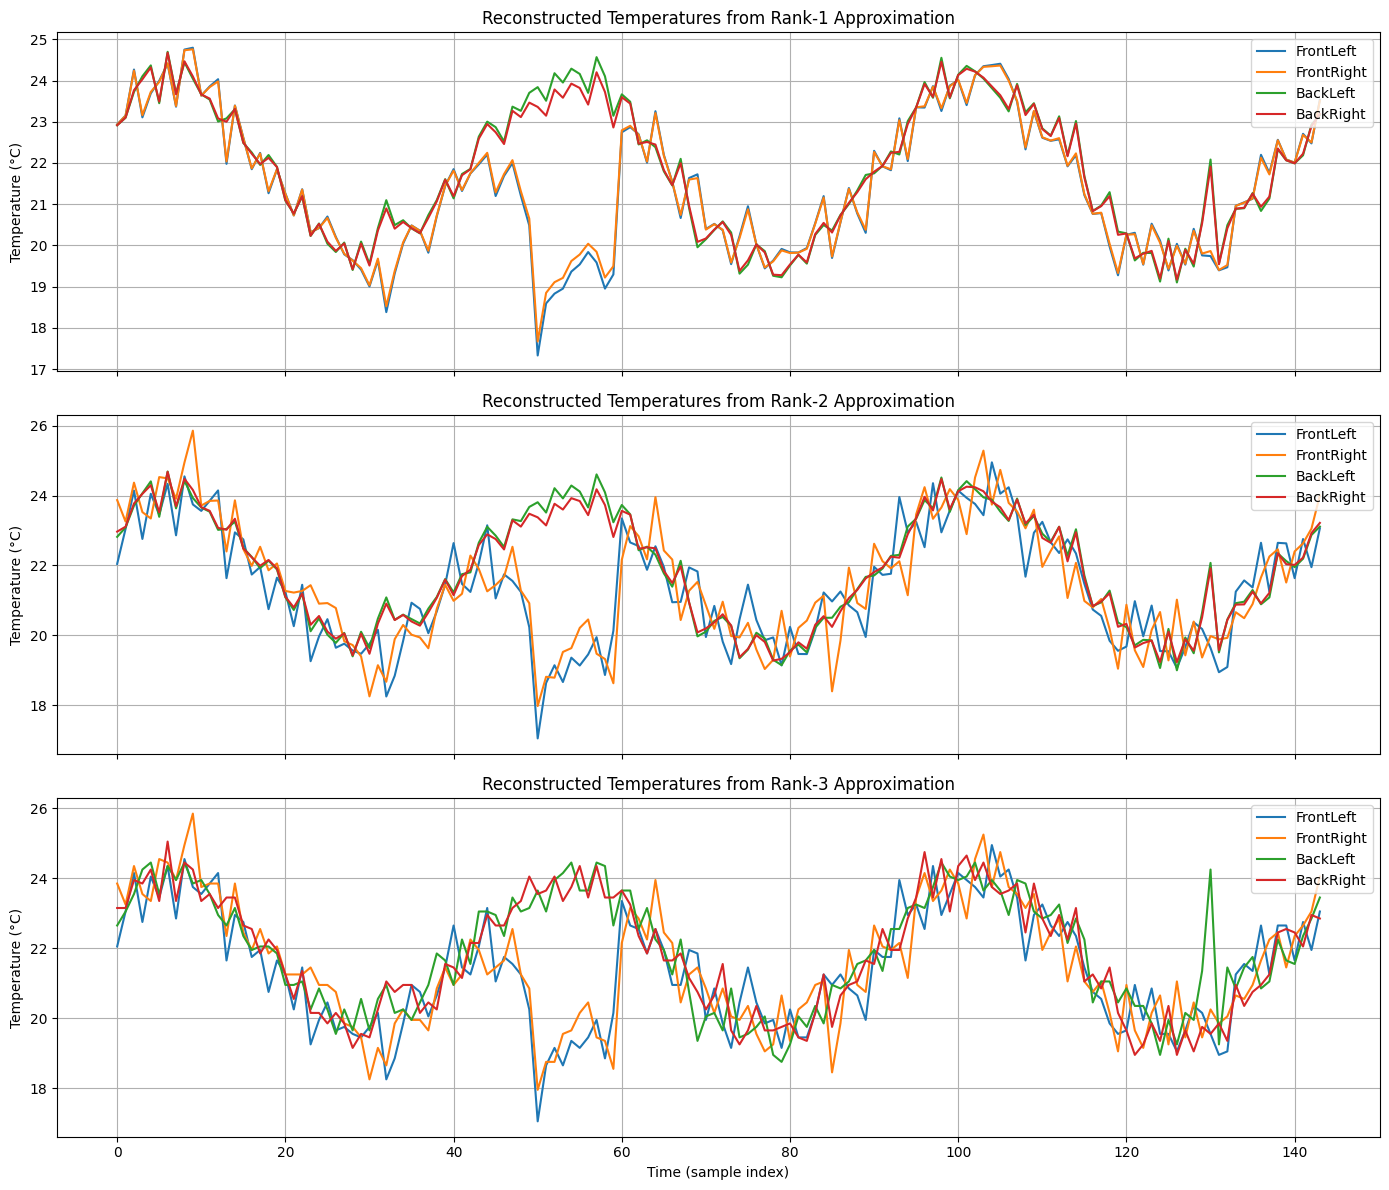

In [ ]:
# Set up the plot
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

for idx, k in enumerate([1, 2, 3]):
    # Truncate to rank-k
    Uk = U[:, :k]
    sk = s[:k]
    VTk = VT[:k, :]

    # Reconstruct the approximation
    Ak_approx = (Uk * sk) @ VTk
    A_reconstructed = Ak_approx + A_mean[:, None]

    # Plot reconstructed values
    axs[idx].set_title(f"Reconstructed Temperatures from Rank-{k} Approximation")
    for i in range(4):
        axs[idx].plot(A_reconstructed[:, i], label=labels[i])

    axs[idx].set_ylabel("Temperature (°C)")
    axs[idx].grid(True)
    axs[idx].legend(loc="upper right")

axs[-1].set_xlabel("Time (sample index)")
plt.tight_layout()
plt.show()

Comment on the results of points 3,4 and 6


# Exercise 2


In [4]:
import numpy as np
from scipy.linalg import solve
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Consider the Boston dataset contained in scikit-learn.

(!) Actually Boston dataset is deprecated then we use the california housing


In [ ]:
# Load California housing dataset
data = fetch_california_housing()
X, y = data.data, data.target

# Split into 60% train, 20% val, 20% test
X_tr, X_rest, y_tr, y_rest = train_test_split(X, y, test_size=0.4, random_state=0)
X_val, X_te, y_val, y_te = train_test_split(
    X_rest, y_rest, test_size=0.5, random_state=0
)

Implement the analytical solution of ridge regression $ (X^TX + \alpha I)w = X^Ty $ using `scipy.linalg.solve`. Compute the solution on the training data. Make sure that the gradient at the solution is zero (up to machine precision).


In [ ]:
# Regularization parameter
alpha = 1.0

# Number of features
n_features = X_tr.shape[1]

# Compute matrices
XtX = X_tr.T @ X_tr  # shape (n_features, n_features)
Xty = X_tr.T @ y_tr  # shape (n_features, )

# Add regularization term alpha * I
A = XtX + alpha * np.eye(n_features)

# Solve linear system A w = Xty
w = solve(A, Xty)

# Check gradient: grad = 2 * (XtX w - Xty + alpha * w)
gradient = 2 * (XtX @ w - Xty + alpha * w)

print("Gradient norm at solution:", np.linalg.norm(gradient))

Gradient norm at solution: 3.214851244427597e-08


Train the models for several possible values of alpha (`alphas = np.logspace(-3, 3, 20)`). Plot the mean squared error on the test set as a function of alpha. Use the validation data to find the best alpha
and display it on the graph.


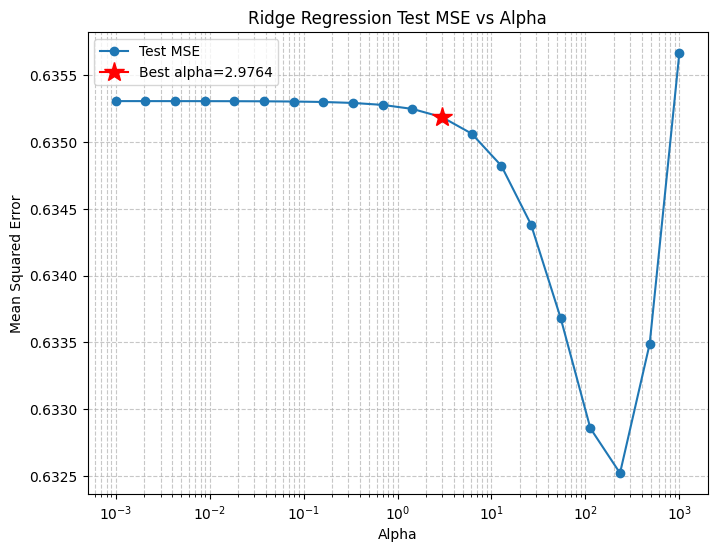

Best alpha based on validation: 2.9764


In [ ]:
alphas = np.logspace(-3, 3, 20)
mse_test = []
mse_val = []

for alpha in alphas:
    # Analytical ridge regression solution
    n_features = X_tr.shape[1]
    A = X_tr.T @ X_tr + alpha * np.eye(n_features)
    b = X_tr.T @ y_tr
    w = solve(A, b)

    # Predict on validation and test sets
    y_val_pred = X_val @ w
    y_test_pred = X_te @ w

    # Compute MSE
    mse_val.append(mean_squared_error(y_val, y_val_pred))
    mse_test.append(mean_squared_error(y_te, y_test_pred))

# Find best alpha based on validation MSE
best_alpha_idx = np.argmin(mse_val)
best_alpha = alphas[best_alpha_idx]

# Plot test MSE vs alpha with best alpha highlighted
plt.figure(figsize=(8, 6))
plt.semilogx(alphas, mse_test, marker="o", label="Test MSE")
plt.semilogx(
    alphas[best_alpha_idx],
    mse_test[best_alpha_idx],
    marker="*",
    markersize=15,
    color="red",
    label=f"Best alpha={best_alpha:.4f}",
)
plt.xlabel("Alpha")
plt.ylabel("Mean Squared Error")
plt.title("Ridge Regression Test MSE vs Alpha")
plt.grid(True, which="both", linestyle="--", alpha=0.7)
plt.legend()
plt.show()

print(f"Best alpha based on validation: {best_alpha:.4f}")

Consider the scaled version of the Boston dataset

(!) Again we use california


In [8]:
from sklearn.preprocessing import StandardScaler

# Load California housing data
data = fetch_california_housing()
X_raw, y_raw = data.data, data.target

# Scale features and targets
X = StandardScaler().fit_transform(X_raw)
y = y_raw - np.mean(y_raw)
y /= np.std(y_raw)

Write a function that computes the stochastic gradient of ridge regression

$$
J(\mathbf{w})={{1}\over{n}}||y - X \mathbf{w}||^2 + {{\alpha}\over{2}} ||\mathbf{w}||^2. \tag{1}
$$

Check that the mean of the stochastic gradient gives the gradient.


In [ ]:
# Ridge regularization parameter
alpha = 1.0


def stochastic_gradient_ridge(w, X_batch, y_batch, alpha):
    m = X_batch.shape[0]
    residual = y_batch - X_batch @ w  # shape (m,)
    grad = (-2 / m) * (X_batch.T @ residual) + alpha * w
    return grad


def full_gradient_ridge(w, X, y, alpha):
    n = X.shape[0]
    residual = y - X @ w
    grad = (-2 / n) * (X.T @ residual) + alpha * w
    return grad


# Example check:

n_samples = X.shape[0]
batch_size = 100

# Initialize weights randomly
w = np.random.randn(X.shape[1])

# Compute full gradient
grad_full = full_gradient_ridge(w, X, y, alpha)

# Compute mean stochastic gradient over all batches
stochastic_grads = []

total_samples = X.shape[0]
batch_size = 100

weighted_sum = np.zeros_like(w)
total_count = 0

for start in range(0, total_samples, batch_size):
    end = min(start + batch_size, total_samples)
    X_batch = X[start:end, :]
    y_batch = y[start:end]
    batch_len = end - start
    g = stochastic_gradient_ridge(w, X_batch, y_batch, alpha)

    weighted_sum += batch_len * g
    total_count += batch_len

mean_stoch_grad = weighted_sum / total_count

print(
    "Norm of (full_grad - mean_stoch_grad):",
    np.linalg.norm(grad_full - mean_stoch_grad),
)

Norm of (full_grad - mean_stoch_grad): 2.4456426630415573e-15


Write a function that implements stochastic gradient descent. Implement two rules for sampling the index: cyclic, and at random. Compare the convergence of both algorithms using the value of alpha found at point 2. What is the role of the step size?


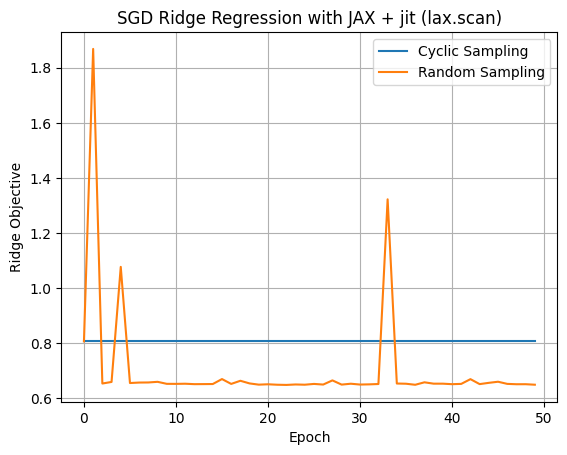

In [ ]:
import jax
import jax.numpy as jnp
from jax import jit, lax
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler


# Ridge regression objective (MSE + L2 regularization)
@jit
def ridge_objective(w, X, y, alpha):
    residual = y - X @ w
    return (jnp.sum(residual**2) / X.shape[0]) + (alpha / 2) * jnp.sum(w**2)


# One SGD step on a single example
@jit
def sgd_step(w, x_i, y_i, alpha, step_size):
    grad = -2 * x_i * (y_i - jnp.dot(x_i, w)) + alpha * w
    w_new = w - step_size * grad
    return w_new


# Run one epoch of SGD over all indices using lax.scan (fully JIT compiled)
def sgd_epoch(w_init, X, y, alpha, step_size, indices):
    def body_fun(w, i):
        x_i, y_i = X[i], y[i]
        w_new = sgd_step(w, x_i, y_i, alpha, step_size)
        return w_new, None  # no carry-over output

    w_final, _ = lax.scan(body_fun, w_init, indices)
    return w_final


# Full SGD training loop with random or cyclic sampling
def sgd_ridge_jax(key, X, y, alpha, step_size, n_epochs, sampling="cyclic"):
    n_samples = X.shape[0]
    w = jnp.zeros(X.shape[1])
    obj_values = []
    indices = jnp.arange(n_samples)

    for epoch in range(n_epochs):
        if sampling == "random":
            key, subkey = jax.random.split(key)
            indices = jax.random.permutation(subkey, indices)
        # else cyclic: indices remain sorted

        w = sgd_epoch(w, X, y, alpha, step_size, indices)
        obj = ridge_objective(w, X, y, alpha)
        obj_values.append(obj.item())

    return w, obj_values


# Load California housing data and preprocess
data = fetch_california_housing()
X_raw, y_raw = data.data, data.target
X_scaled = StandardScaler().fit_transform(X_raw)
y_centered = y_raw - y_raw.mean()
y_scaled = y_centered / y_raw.std()

# Convert to JAX arrays
X = jnp.array(X_scaled)
y = jnp.array(y_scaled)

# Parameters
key = jax.random.PRNGKey(0)
alpha = 1.0
step_size = 1e-3
n_epochs = 50

# Train using cyclic sampling
w_cyclic, obj_cyclic = sgd_ridge_jax(
    key, X, y, alpha, step_size, n_epochs, sampling="cyclic"
)
# Train using random sampling
w_random, obj_random = sgd_ridge_jax(
    key, X, y, alpha, step_size, n_epochs, sampling="random"
)

# Plot results
plt.plot(obj_cyclic, label="Cyclic Sampling")
plt.plot(obj_random, label="Random Sampling")
plt.xlabel("Epoch")
plt.ylabel("Ridge Objective")
plt.title("SGD Ridge Regression with JAX + jit (lax.scan)")
plt.legend()
plt.grid(True)
plt.show()

Step size (learning rate) controls the size of each update.

Too large → overshoot minima, cause divergence or oscillations.

Too small → slow convergence, may take many epochs to reach minimum.

It balances speed and stability of learning.

Usually tuned via validation, sometimes adaptively e.g., learning rate schedules
